In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
import transformers
from transformers import AutoConfig, TFAutoModel,AutoModel, AutoTokenizer
import matplotlib.pyplot as plt


bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Download model and configuration from huggingface.co and cache.
bert_model_tf = TFAutoModel.from_pretrained("bert-base-cased")
bert_model_tf_0 = TFAutoModel.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
"""
This section contains various functions for perturbing modules and evaluating model disagreements.
"""
def perturb_module_weights(module, module_0):
  # Perturbs the weights of the supplied module, based on the reference module's weights.
  # Args:
  #   module: the dense layer to be perturbed, e.g. bert_model_tf.bert.encoder.layer[0].attention.submodules[0].query
  #   module_0: weights to derive perturbations from. Same structure as module.
  # sanity check: print(f"Module perturbation std {tf.math.reduce_mean(tf.math.reduce_std(module_0.weights[0]))}")
  perturbed_weight = module_0.weights[0] + tf.random.normal(module_0.weights[0].shape, stddev=tf.math.reduce_std(module_0.weights[0]))
  # Can also use fixed perturbation magnitude, e.g. mean std across all layers.
  # perturbed_weight = module_0.weights[0] + tf.random.normal(module_0.weights[0].shape, stddev=0.02)
  perturbed_bias = module_0.weights[1] + tf.random.normal(module_0.weights[1].shape, stddev=tf.math.reduce_std(module_0.weights[1]))
  module.set_weights([perturbed_weight, perturbed_bias])

def reset_module_weights(module, module_0):
  # Resets the module weights,  based on the reference module's weights.
  # Args:
  #   module: the dense layer to be perturbed, e.g. bert_model_tf.bert.encoder.layer[0].attention.submodules[0].query
  #   module_0: weights to reset module with. Same structure as module.
  module.set_weights([module_0.weights[0], module_0.weights[1]])

def evaluate_output_diff(model, model_0, tokenizer, inputs):
  # Evaluates output difference between two models
  tokenized_inputs = tokenizer(inputs, return_tensors="tf", padding=True)
  outputs = model(tokenized_inputs)
  outputs_0 = model_0(tokenized_inputs)
  abs_diff = tf.math.abs(outputs['pooler_output'] - outputs_0['pooler_output'])
  return tf.reduce_mean(abs_diff)

def output_diff_for_module_index(module_idx, module_name="query"):
  # Evaluates model disagreements for the indicated module at layer module_idx.
  layer = bert_model_tf.bert.encoder.layer[module_idx]
  layer_0 = bert_model_tf_0.bert.encoder.layer[module_idx]
  if module_name == "dense":
    module_to_use = layer.attention.dense_output
  else:
    module_to_use = layer.attention.self_attention
  module = getattr(module_to_use, module_name)
  module_0 = getattr(module_to_use, module_name)

  perturb_module_weights(module,
                         module_0)
  output_diff = evaluate_output_diff(bert_model_tf, bert_model_tf_0, bert_tokenizer, sentences)
  reset_module_weights(module,
                       module_0)
  return output_diff

def output_diff_for_all_module_indices(layer_key="value"):
  # Evaluates value layer ranks.
  n_modules = 12
  n_trials = 3
  from collections import defaultdict
  module_diffs = defaultdict(float)
  module_std = defaultdict(float)

  for module_idx in range(n_modules):
    if layer_key == "value":
      cur_diffs = [output_diff_for_module_index(module_idx, "value") for _ in range(n_trials)]
    elif layer_key == "query":
      cur_diffs = [output_diff_for_module_index(module_idx, "query") for _ in range(n_trials)]
    else:
      raise ValueError(f"Unknown layer key {layer_key}")
    module_diffs[module_idx] = tf.reduce_mean(cur_diffs)
    module_std[module_idx] = tf.math.reduce_std(cur_diffs)

  # print(f"{layer_key} module diffs {module_diffs}")
  # print(f"{layer_key} module std {module_std}")
  return module_diffs, module_std

sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Among the singles released from the album were the songs \"Be My Lover\" and \"Hard To Stay Awake\".",
  "Riccardo Zegna is an Italian jazz musician.",
  "Rajko Maksimović is a composer, writer, and music pedagogue.",
  "One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

def plot_module_diff(module_diffs, module_std, layer_key="value", n_modules=12):
  # Plots the module importance scores, based on model disagreements.
  # plt.scatter(list(range(n_modules)), list(module_diffs.values()), marker='x', label='Model disagreement')
  plt.errorbar(list(range(n_modules)), list(module_diffs.values()), yerr=list(module_std.values()),
               marker='x', label='Bert Model disagreement')

  plt.legend(fontsize=13)
  plt.title(f'Bert Model disagreement increases w.r.t. index of perturbed {layer_key} layer', fontsize=15)
  plt.xlabel(f'Index of perturbed {layer_key} layer', fontsize=15)
  plt.ylabel('Bert Model output disagreement', fontsize=15)

from typing import List
def create_ranks_from_disagreement(
    disagreement: List[float], average_rank: int = 8
):
  """Creates a list of ranks from a list of model disagreement values."""
  # Disagreement values are assumed to be non-negative.
  disagreement = tf.convert_to_tensor(disagreement)
  disagreement_sum = tf.math.reduce_sum(disagreement)
  total_rank = average_rank * len(disagreement)
  scaled_disagreement = (
      tf.math.divide(total_rank, disagreement_sum) * disagreement
  )
  disagreement = tf.cast(tf.math.floor(scaled_disagreement), dtype=tf.int32)
  return disagreement, ','.join(str(int(d)) for d in disagreement)


defaultdict(<class 'float'>, {0: 0.1067335, 1: 0.2673352, 2: 0.5113052, 3: 0.64961135, 4: 0.66023976, 5: 0.6209688, 6: 0.59066254, 7: 0.61314476, 8: 0.6017301, 9: 0.72589016, 10: 0.72327375, 11: 0.570347})
[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
defaultdict(<class 'float'>, {0: 0.06512618, 1: 0.08032881, 2: 0.1250961, 3: 0.021135513, 4: 0.030625999, 5: 0.030754842, 6: 0.046523977, 7: 0.018294664, 8: 0.06604415, 9: 0.024329448, 10: 0.04602122, 11: 0.11850081})
1,3,7,9,9,8,8,8,8,10,10,8


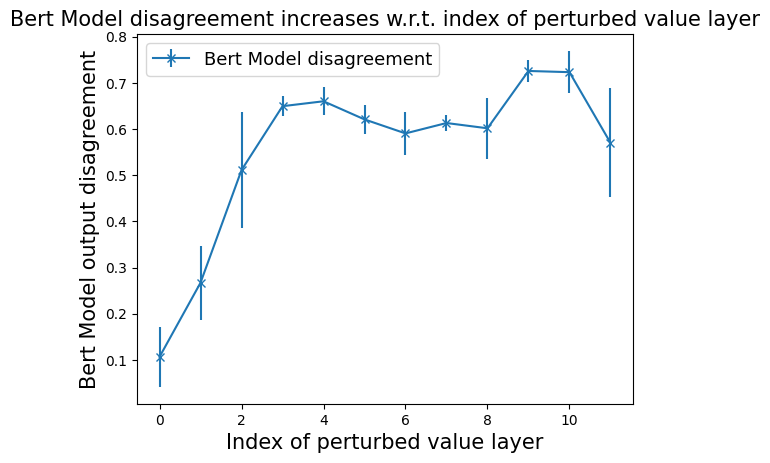

In [ ]:
# @title Evaluating layer ranks for the value module.
module_name = "value"
n_modules = 12
n_trials = 5
from collections import defaultdict
module_diffs = defaultdict(float)
module_std = defaultdict(float)

for module_idx in range(n_modules):
  cur_diffs = [output_diff_for_module_index(module_idx, module_name) for _ in range(n_trials)]
  module_diffs[module_idx] = tf.reduce_mean(cur_diffs).numpy()
  module_std[module_idx] = tf.math.reduce_std(cur_diffs).numpy()

print(module_diffs)
print(list(module_diffs.values()))
# print(module_std)
print(f"std: {list(module_std.values())}")

print(create_ranks_from_disagreement(list(module_diffs.values())))
plot_module_diff(module_diffs, module_std, layer_key=module_name, n_modules=12)

defaultdict(<class 'float'>, {0: 0.083476424, 1: 0.1386449, 2: 0.15169092, 3: 0.15550506, 4: 0.19022527, 5: 0.23578437, 6: 0.26204735, 7: 0.2828268, 8: 0.31076545, 9: 0.32095137, 10: 0.3350768, 11: 0.3348988})
[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
module_std defaultdict(<class 'float'>, {0: 0.02819717, 1: 0.005647352, 2: 0.008877718, 3: 0.005140435, 4: 0.022494953, 5: 0.012557124, 6: 0.013753076, 7: 0.010831864, 8: 0.00930183, 9: 0.0034257835, 10: 0.0043131337, 11: 0.0096404925})
1,2,2,2,3,4,4,4,5,5,5,5


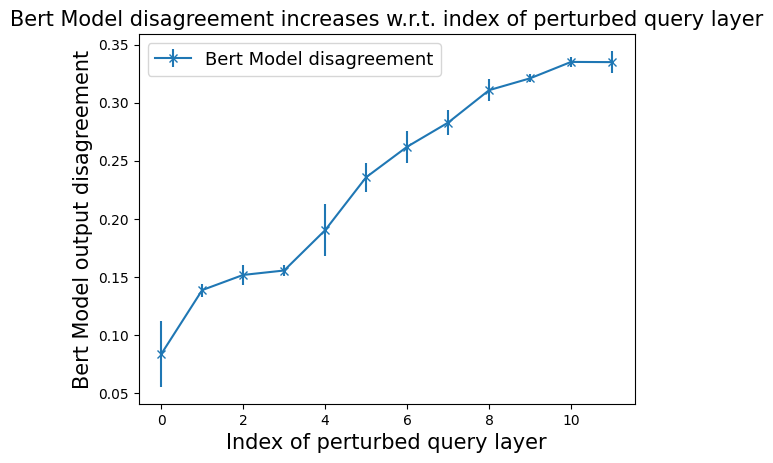

In [ ]:
# @title Evaluating layer ranks for the query module.
module_name = "query"
n_modules = 12
n_trials = 7
from collections import defaultdict
module_diffs = defaultdict(float)
module_std = defaultdict(float)

for module_idx in range(n_modules):
  cur_diffs = [output_diff_for_module_index(module_idx, module_name) for _ in range(n_trials)]
  module_diffs[module_idx] = tf.reduce_mean(cur_diffs).numpy()
  module_std[module_idx] = tf.math.reduce_std(cur_diffs).numpy()

print(module_diffs)
print(list(module_diffs.values()))

#print(f"module_std {module_std}")
print(f"std: {list(module_std.values())}")

print(create_ranks_from_disagreement(list(module_diffs.values())))
plot_module_diff(module_diffs, module_std, layer_key=module_name, n_modules=12)
query_module_diffs = module_diffs
query_module_std = module_std

In [ ]:
# @title Rank Prediction
query_module_diffs=[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
# key_module_diffs=[0.24639809, 0.26325554, 0.23876426, 0.23999164, 0.27572364, 0.27560118, 0.258705, 0.2741065, 0.2712388, 0.27132052, 0.27131975, 0.27131975]
key_module_diffs=[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
dense_module_diffs=[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]

# dense_module_diffs=[0.3140601, 0.38075718, 0.37752995, 0.37574968, 0.3209025, 0.32092157, 0.30064198, 0.37931755, 0.36589435, 0.32185915, 0.3673533, 0.35489583]
value_module_diffs=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
print(f"query: {create_ranks_from_disagreement(query_module_diffs, 8)}")
print(f"key: {create_ranks_from_disagreement(key_module_diffs, 8)}")
print(f"value: {create_ranks_from_disagreement(value_module_diffs, 8)}")
print(f"dense: {create_ranks_from_disagreement(dense_module_diffs, 8)}")

query: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 2,  4,  5,  5,  6,  8,  8,  9, 10, 10, 11, 11], dtype=int32)>, '2,4,5,5,6,8,8,9,10,10,11,11')
key: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 1,  2,  4,  5,  7,  8,  8, 10, 11, 11, 11, 11], dtype=int32)>, '1,2,4,5,7,8,8,10,11,11,11,11')
value: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 1,  3,  7,  9,  9,  8,  8,  8,  8, 10, 10,  8], dtype=int32)>, '1,3,7,9,9,8,8,8,8,10,10,8')
dense: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([5, 7, 7, 7, 8, 9, 8, 9, 8, 9, 8, 6], dtype=int32)>, '5,7,7,7,8,9,8,9,8,9,8,6')


In [ ]:
import tensorflow as tf
query_module_diffs=[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
#key_module_diffs=[0.24639809, 0.26325554, 0.23876426, 0.23999164, 0.27572364, 0.27560118, 0.258705, 0.2741065, 0.2712388, 0.27132052, 0.27131975, 0.27131975]
key_module_diffs=[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
dense_module_diffs=[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]

value_module_diffs=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
#dense_module_diffs=[0.3140601, 0.38075718, 0.37752995, 0.37574968, 0.3209025, 0.32092157, 0.30064198, 0.37931755, 0.36589435, 0.32185915, 0.3673533, 0.35489583]

# print([sum(query_module_diffs)/12, sum(key_module_diffs)/12, sum(value_module_diffs)/12], sum(dense_module_diffs)/12, )

all_module_diffs=[*query_module_diffs, *key_module_diffs, *value_module_diffs, *dense_module_diffs]
all_ranks, _ = create_ranks_from_disagreement(all_module_diffs, 8)
print(','.join([str(int(d)) for d in all_ranks[:12]]), ','.join([str(int(d)) for d in all_ranks[12:24]]),
      ','.join([str(int(d)) for d in all_ranks[24:36]]), ','.join([str(int(d)) for d in all_ranks[36:]]))

1,2,3,3,3,4,5,5,6,6,6,6 0,1,2,3,4,4,5,5,6,7,6,6 2,5,10,13,13,12,12,12,12,15,15,11 7,9,10,10,11,12,11,12,12,12,12,8


In [ ]:
import tensorflow as tf
query_module_diffs=[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
#key_module_diffs=[0.24639809, 0.26325554, 0.23876426, 0.23999164, 0.27572364, 0.27560118, 0.258705, 0.2741065, 0.2712388, 0.27132052, 0.27131975, 0.27131975]
key_module_diffs=[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
dense_module_diffs=[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]

value_module_diffs=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
#dense_module_diffs=[0.3140601, 0.38075718, 0.37752995, 0.37574968, 0.3209025, 0.32092157, 0.30064198, 0.37931755, 0.36589435, 0.32185915, 0.3673533, 0.35489583]

all_module_diffs=[*query_module_diffs, *key_module_diffs, *value_module_diffs, *dense_module_diffs]
all_ranks, _ = create_ranks_from_disagreement(all_module_diffs, 16)
print(','.join([str(int(d)) for d in all_ranks[:12]]), ','.join([str(int(d)) for d in all_ranks[12:24]]),
      ','.join([str(int(d)) for d in all_ranks[24:36]]), ','.join([str(int(d)) for d in all_ranks[36:]]))

3,6,6,7,8,10,11,12,14,14,15,15 11,12,10,10,12,12,11,12,12,12,12,12 4,12,23,29,30,28,27,28,27,33,33,26 14,17,17,17,14,14,13,17,16,14,16,16


In [ ]:
# @title Rank Prediction for Rank 16
import tensorflow as tf
query_module_diffs=[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
#key_module_diffs=[0.24639809, 0.26325554, 0.23876426, 0.23999164, 0.27572364, 0.27560118, 0.258705, 0.2741065, 0.2712388, 0.27132052, 0.27131975, 0.27131975]
key_module_diffs=[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
dense_module_diffs=[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]

#dense_module_diffs=[0.3140601, 0.38075718, 0.37752995, 0.37574968, 0.3209025, 0.32092157, 0.30064198, 0.37931755, 0.36589435, 0.32185915, 0.3673533, 0.35489583]
value_module_diffs=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
print(f"query: {create_ranks_from_disagreement(query_module_diffs, 16)}")
print(f"key: {create_ranks_from_disagreement(key_module_diffs, 16)}")
print(f"value: {create_ranks_from_disagreement(value_module_diffs, 16)}")
print(f"dense: {create_ranks_from_disagreement(dense_module_diffs, 16)}")

query: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 5,  9, 10, 10, 13, 16, 17, 19, 21, 21, 22, 22], dtype=int32)>, '5,9,10,10,13,16,17,19,21,21,22,22')
key: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([14, 16, 14, 14, 16, 16, 15, 16, 16, 16, 16, 16], dtype=int32)>, '14,16,14,14,16,16,15,16,16,16,16,16')
value: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 3,  7, 14, 18, 19, 17, 17, 17, 17, 20, 20, 16], dtype=int32)>, '3,7,14,18,19,17,17,17,17,20,20,16')
dense: (<tf.Tensor: shape=(12,), dtype=int32, numpy=array([14, 17, 17, 17, 14, 14, 13, 17, 16, 14, 16, 16], dtype=int32)>, '14,17,17,17,14,14,13,17,16,14,16,16')


defaultdict(<class 'float'>, {0: 0.033799376, 1: 0.076967776, 2: 0.13152294, 3: 0.16135047, 4: 0.2009354, 5: 0.23468475, 6: 0.2515475, 7: 0.28742248, 8: 0.32996643, 9: 0.33730012, 10: 0.33189198, 11: 0.33563563})
[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
std: [0.020257132, 0.031922154, 0.011508722, 0.0142679615, 0.019349411, 0.013065412, 0.0036683579, 0.021342171, 0.007035571, 0.004800473, 0.0048742956, 0.015380475]
(<tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 1,  2,  4,  5,  7,  8,  8, 10, 11, 11, 11, 11], dtype=int32)>, '1,2,4,5,7,8,8,10,11,11,11,11')


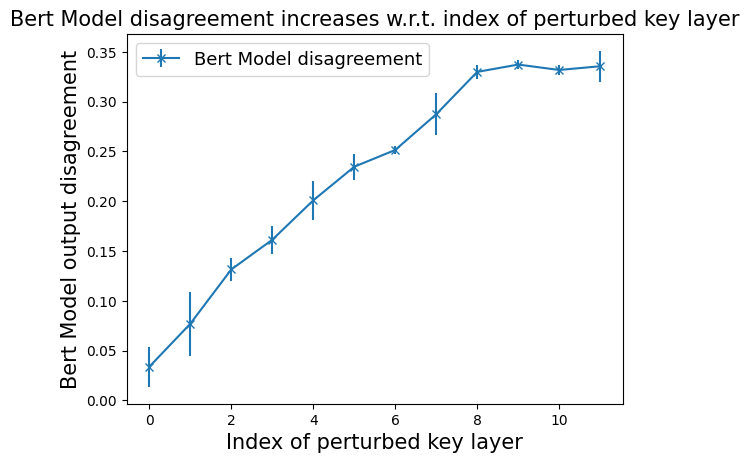

In [ ]:
# @title Evaluating layer ranks for the key module.
module_name = "key"
n_modules = 12
n_trials = 5
from collections import defaultdict
module_diffs = defaultdict(float)
module_std = defaultdict(float)

for module_idx in range(n_modules):
  cur_diffs = [output_diff_for_module_index(module_idx, module_name) for _ in range(n_trials)]
  module_diffs[module_idx] = tf.reduce_mean(cur_diffs).numpy()
  module_std[module_idx] = tf.math.reduce_std(cur_diffs).numpy()

print(module_diffs)
print(list(module_diffs.values()))

print(f"std: {list(module_std.values())}")
# print(module_std)
print(create_ranks_from_disagreement(list(module_diffs.values())))
plot_module_diff(module_diffs, module_std, layer_key=module_name, n_modules=12)

defaultdict(<class 'float'>, {0: 0.33768645, 1: 0.46251282, 2: 0.50760823, 3: 0.5119684, 4: 0.55298114, 5: 0.59392816, 6: 0.5549153, 7: 0.59454644, 8: 0.57808244, 9: 0.59831434, 10: 0.5870656, 11: 0.4229684})
[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]
defaultdict(<class 'float'>, {0: 0.01913817, 1: 0.05069129, 2: 0.011989572, 3: 0.039826967, 4: 0.02750514, 5: 0.03088608, 6: 0.03948507, 7: 0.032965284, 8: 0.021036295, 9: 0.031934004, 10: 0.03184671, 11: 0.06273963})
(<tf.Tensor: shape=(12,), dtype=int32, numpy=array([5, 7, 7, 7, 8, 9, 8, 9, 8, 9, 8, 6], dtype=int32)>, '5,7,7,7,8,9,8,9,8,9,8,6')


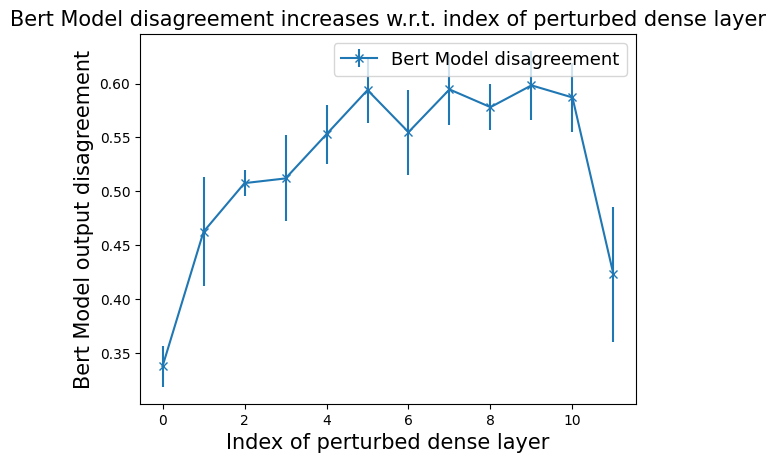

In [ ]:
# @title Evaluating layer ranks for the FFN module.
module_name = "dense"
n_modules = 12
n_trials = 5
from collections import defaultdict
module_diffs = defaultdict(float)
module_std = defaultdict(float)

for module_idx in range(n_modules):
  cur_diffs = [output_diff_for_module_index(module_idx, module_name) for _ in range(n_trials)]
  module_diffs[module_idx] = tf.reduce_mean(cur_diffs).numpy()
  module_std[module_idx] = tf.math.reduce_std(cur_diffs).numpy()

print(module_diffs)
print(list(module_diffs.values()))
print(list(module_std.values()))
print(module_std)
print(create_ranks_from_disagreement(list(module_diffs.values())))
plot_module_diff(module_diffs, module_std, layer_key=module_name, n_modules=12)

In [ ]:
# @title Ablation
import tensorflow as tf
random_vec = tf.random.uniform(shape=(12,), minval=0, maxval=1)
print(f"random: {create_ranks_from_disagreement(random_vec, 8)}")


query: 12,7,11,2,11,7,9,3,9,1,9,9


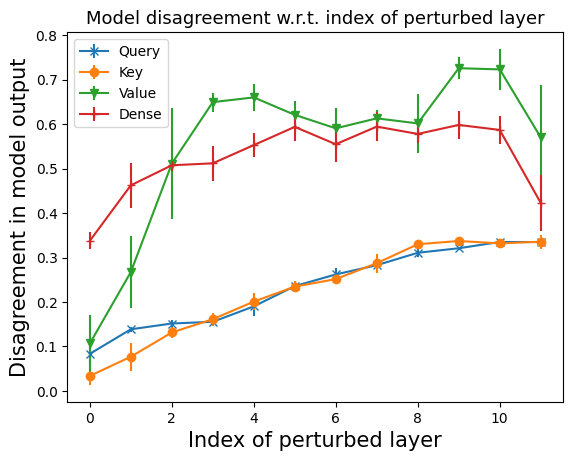

In [ ]:
# @title Plotting
import matplotlib.pyplot as plt
import numpy as np
query_module_diffs=[0.083476424, 0.1386449, 0.15169092, 0.15550506, 0.19022527, 0.23578437, 0.26204735, 0.2828268, 0.31076545, 0.32095137, 0.3350768, 0.3348988]
key_module_diffs=[0.033799376, 0.076967776, 0.13152294, 0.16135047, 0.2009354, 0.23468475, 0.2515475, 0.28742248, 0.32996643, 0.33730012, 0.33189198, 0.33563563]
value_module_diffs=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
dense_module_diffs=[0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]

query_module_std=list({0: 0.02819717, 1: 0.005647352, 2: 0.008877718, 3: 0.005140435, 4: 0.022494953, 5: 0.012557124, 6: 0.013753076, 7: 0.010831864, 8: 0.00930183, 9: 0.0034257835, 10: 0.0043131337, 11: 0.0096404925}.values())
key_module_std=[0.020257132, 0.031922154, 0.011508722, 0.0142679615, 0.019349411, 0.013065412, 0.0036683579, 0.021342171, 0.007035571, 0.004800473, 0.0048742956, 0.015380475]
value_module_std=list({0: 0.06512618, 1: 0.08032881, 2: 0.1250961, 3: 0.021135513, 4: 0.030625999, 5: 0.030754842, 6: 0.046523977, 7: 0.018294664, 8: 0.06604415, 9: 0.024329448, 10: 0.04602122, 11: 0.11850081}.values())
dense_module_std=list({0: 0.01913817, 1: 0.05069129, 2: 0.011989572, 3: 0.039826967, 4: 0.02750514, 5: 0.03088608, 6: 0.03948507, 7: 0.032965284, 8: 0.021036295, 9: 0.031934004, 10: 0.03184671, 11: 0.06273963}.values())

importances=[0.1067335, 0.2673352, 0.5113052, 0.64961135, 0.66023976, 0.6209688, 0.59066254, 0.61314476, 0.6017301, 0.72589016, 0.72327375, 0.570347]
importances_std = [.1]*12

data={"x": list(range(2))*2, "query_diff":[1,2], "query_std":[1,2]+[.1,.2], "legend":[1]*2+[2]*2}

def plot_module_diff(module_diffs, module_std, layer_key="value", n_modules=12):
  # plt.errorbar(list(range(n_modules)), list(module_diffs), yerr=list(module_std),
  #             marker='x', label='Model disagreement')

  # sns.lineplot(data=data, x="x", y="query_diff", hue=["query_diff",]*len(data["query_diff"]),style=["query_diff",]*len(data["query_diff"]))
  # sns.lineplot(data=data, x="x", y="query_diff",hue="legend",style="legend",errorbar=lambda x: [.3]*4 )
  #sns.lineplot(data=data,style="legend")
  plt.errorbar(list(range(len(importances))), y=query_module_diffs, yerr=query_module_std, marker='x', label='Query')
  plt.errorbar(list(range(len(importances))), y=key_module_diffs, yerr=key_module_std,marker='o', label='Key')
  plt.errorbar(list(range(len(importances))), y=value_module_diffs,yerr=value_module_std, marker='v', label='Value')
  plt.errorbar(list(range(len(importances))), y=dense_module_diffs, yerr=dense_module_std,marker='+', label='Dense')
  #dense [0.33768645, 0.46251282, 0.50760823, 0.5119684, 0.55298114, 0.59392816, 0.5549153, 0.59454644, 0.57808244, 0.59831434, 0.5870656, 0.4229684]
  # defaultdict(<class 'float'>, {0: 0.01913817, 1: 0.05069129, 2: 0.011989572, 3: 0.039826967, 4: 0.02750514, 5: 0.03088608, 6: 0.03948507, 7: 0.032965284, 8: 0.021036295, 9: 0.031934004, 10: 0.03184671, 11: 0.06273963})

  plt.title(f'Model disagreement w.r.t. index of perturbed layer', fontsize=13)
  plt.xlabel(f'Index of perturbed layer', fontsize=15)
  plt.legend()
  plt.ylabel('Disagreement in model output', fontsize=15)


plot_module_diff(importances, importances_std)
